# Network Embedding
### Skip-Gram & SGD & Embedding Vector



### 목표 : Karate Graph를 Input으로, 2차원의 Embedding Vector로 표현하라

http://konect.cc/networks/ucidata-zachary/

# 1. Import Dataset 

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from random import shuffle
from copy import copy

%matplotlib inline

In [2]:
edge = pd.read_csv('karate_club.edgelist', sep=' ', names=['x','y','w'])

In [3]:
edge.head()

,x,y,w
0,0,1,{}
1,0,2,{}
2,0,3,{}
3,0,4,{}
4,0,5,{}


In [3]:
graph = nx.Graph()
for i in range(edge.shape[0]):
    graph.add_node(node_for_adding = edge['x'][i])
    graph.add_node(node_for_adding = edge['y'][i])
    graph.add_edge(edge['x'][i], edge['y'][i])

C:\Users\samsung\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


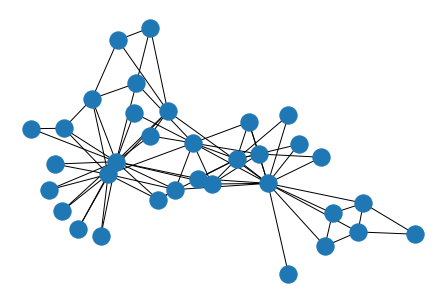

In [4]:
nx.draw(graph,with_label=True)

### 1) Adjacency Matrix

In [5]:
A = nx.to_numpy_matrix(graph, nodelist=sorted(graph.nodes()))

In [6]:
A

matrix([[0., 1., 1., ..., 1., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]])

### 2). Input Word Vector ( One-Hot encoded )

In [7]:
OH = np.identity(34)

In [8]:
OH

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# 2. Define Functions
- 1) random step 
- 2) softmax
- 3) feed forward
- 4) back propagation

### 1). Random Walk

In [9]:
def random_step(i,w):
    walk_list = []
    walk_list.append(i)
    for k in range(w):
        ad = np.nonzero(A[i])[1] # i와 인접한 vertex들의 list
        rand = random.choice(ad) # 그 list중 랜덤하게 하나 고르기
        walk_list.append(rand)
        i = rand
    return walk_list

In [78]:
random_step(3,10)

[3, 2, 1, 21, 0, 21, 1, 0, 21, 1, 19]

### 2) softmax

In [93]:
def softmax(x):
    c = np.max(x)
    b = c-x
    exp_x = np.exp(b)
    sum_exp_x = np.sum(exp_x)
    y = exp_x / sum_exp_x
    return y

### 3) Feed Forward

In [94]:
def feedforward(input_word,index,w1,w2):
    h=np.matmul(w1.T,input_word[index])
    u=np.matmul(w2.T,h)
    y = softmax(u)
    return h,u,y     

### 4) Back Propagation

In [95]:
def backprop(input_word,w1,w2,lr,h,y_pred,index,window_size):
    front = input_word[index-window_size : index]
    back = input_word[index+1 : index+window_size+1]
    window_OH = np.concatenate([front,back])
    
    # output -> hidden
    for j in range(w2.shape[1]):
        adjust = (y_pred-window_OH)[:,j].sum()*h
        w2[:,j] -= -lr*adjust
        
    # hidden -> input
    adjust2 = ((y_pred-window_OH).sum(axis=0)*w2).T
    w1-= lr*adjust2
    return w1,w2    

# 3. Skip-Gram

In [96]:
def Skipgram(input_word, reduced_dim, lr, walk_size, window_size,epoch):
    #W1 = np.random.normal(0,0.1,(input_word.shape[0], reduced_dim)) # Input -> Hidden
    W1 = np.random.random((input_word.shape[0],reduced_dim))
    #W2 = np.random.normal(0,0.1,(reduced_dim,input_word.shape[0])) # Hidden -> Output
    W2 = np.random.random((reduced_dim, input_word.shape[0]))
    for _ in range(epoch):
        input_word = copy(input_word)
        shuffle(input_word)
        for index in range(input_word.shape[0]):
            RW = input_word[random_step(index,walk_size)]
            for i in range(len(RW)):
                h,u,y = feedforward(RW,i,W1,W2)
                W1,W2 = backprop(RW,W1,W2,lr,h,y,i,window_size)
    return W1,W2

# 4. Result

In [308]:
w1,w2 = Skipgram(OH,reduced_dim=2, lr=0.02,
                 walk_size=10,window_size=3,epoch=7)

In [309]:
Emb = np.matmul(OH,w1)

In [310]:
Emb_df = pd.DataFrame({'X':Emb[:,0], 'Y':Emb[:,1],'Label':range(1,35)})

blue = [1,2,3,4,5,6,7,8,9,11,12,13,14,17,18,20,22]
red = list(set(range(0,34))-set(blue))

Emb_df.loc[Emb_df.Label.isin(blue),'Color']=1
Emb_df.loc[Emb_df.Label.isin(red),'Color']=0

### Visualization

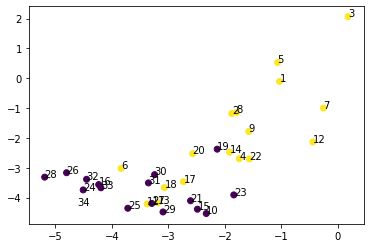

In [311]:
plt.scatter(Emb_df['X'], Emb_df['Y'], c=Emb_df['Color'])

for i,txt in enumerate(Emb_df['Label']):
    plt.annotate(txt, (Emb_df['X'][i], Emb_df['Y'][i]))